DataEntryAudit20210720 (1).xls downloaded.
199853
199871
199875
199911
199915
199935
199822
199850
199858
199866
199872
199912
199932
199940
199944
199828
199870
199910
199918
199926
199938
199835
199839
199843
199847
199859
199863
199867
199873
199877
199925
199929
199933
199937
199945
file saved!
            Load
Entry Hour      
8              3
9              5
10             4
11             7
13             4
14             6
15             3
16             3
Image Saved!
email sent


True

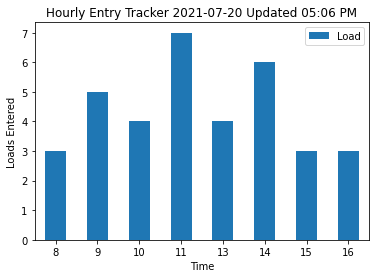

In [1]:
from selenium import webdriver
from datetime import date, datetime, timedelta
import time
import os
import pandas as pd
import numpy as np

from outlook_send import send_email
from IPython.display import display, HTML

# constant to establish download folder path, only need to change this to change location
DOWNLOAD_FOLDER = r"C:\Users\boa.sokchu\Downloads"

# list of files before downloading
before = os.listdir(DOWNLOAD_FOLDER)

# activate chrome driver
browser = webdriver.Chrome()
browser.maximize_window()
browser.get("https://boa.3plsystemscloud.com/")

# page elements to login
boa_user = browser.find_element_by_id("txb-username")
boa_pw = browser.find_element_by_id("txb-password")
login_button = browser.find_element_by_id("ctl00_ContentBody_butLogin")

# login credentials
boa_user.send_keys("sokchu@boalogistics.com")
boa_pw.send_keys("Immuneact10!")
login_button.click()

# enter report code into report_code variable
# "Data Entry Audit" report
report_code = "72A74D746D4D"
url = "https://boa.3plsystemscloud.com/App_BW/staff/Reports/ReportViewer.aspx?code="+report_code
browser.get(url)

# sets up start date and end date for filter
today = date.today()
s_date = today
e_date = today
start = s_date.strftime("%m/%d/%Y 00:00:00")
end = e_date.strftime("%m/%d/%Y 23:59:59")

#Manual date
#start = "06/29/2021 00:00:00"
#end = "06/29/2021 23:59:59"

enteredby = "Order Entry 1"

# set up variables for parameter fields
startbox = browser.find_element_by_xpath("//td[1]/input[@class='filter between'][1]")
endbox = browser.find_element_by_xpath("//td[1]/input[@class='filter between'][2]")
enteredbybox = browser.find_element_by_xpath("//*[@id='table-wherevalue']/td[2]/input")

# inserts new parameters
startbox.clear()
startbox.send_keys(start)
endbox.clear()
endbox.send_keys(end)
enteredbybox.clear()
enteredbybox.send_keys(enteredby)

# save & view report, then download
save_button = browser.find_element_by_id("ctl00_ContentBody_butSaveView").click()
browser.implicitly_wait(3)
download = browser.find_element_by_id("ctl00_ContentBody_butExportToExcel").click()

#need to wait a few seconds before continuing to allow for file to finish downloading.

time.sleep(3)


#compares list of files in Downloads folder after downloading file to extract filename
after = os.listdir(DOWNLOAD_FOLDER)
change = set(after) - set(before)

if len(change) == 1:
    file_name = change.pop()
    print(file_name + " downloaded.")
else:
    print ("More than one file or no file downloaded")
    
# sets filepath to downloaded file and create DataFrame from file, grabs Load # column
filepath = DOWNLOAD_FOLDER + "\\" + file_name
data = pd.read_html(filepath)
df = data[0]
df.fillna('',inplace=True)
#print(df)
load_list_full = df['Load #']

# removes last row of column and convert to string
last = len(load_list_full) - 1
load_list_int = load_list_full[0:last]
load_list = map(str, load_list_int)
#print(load_list)

#Create Hourly Tracker File
fname = 'Hourly_Tracker.csv'
f = open(fname,'w+',encoding="utf-8")
f.write("Load,Entry Date,Entry Time,Entry Hour,Entry Hour (AM/PM)")

#Grabs date and Time info from each load
for x in load_list:
    load_id = x
    print(load_id)
    #Shipment Notes Page
    shipment_url = 'http://boa.3plsystemscloud.com/App_BW/staff/shipment/shipmentNotes.aspx?showpop=0&loadid='+load_id
    browser.get(shipment_url)
    
    #Get number of table rows
    rows = browser.find_elements_by_xpath("//table/tbody/tr")
    row_length = len(rows)
    
    #Calculate the row number
    row_num_int = row_length - 15
    row_num = str(row_num_int).zfill(2)
    
    #Find first shipment note entry
    table = browser.find_element_by_id("ctl00_BodyContent_RepeaterNotes_ctl" + row_num + "_TableRowItemTop")
    Table = table.text
    
    #Extract desired info only
    TABLE = Table[4:]
    splitTABLE = TABLE.split("PT", 1)
    subTABLE1 = splitTABLE[0]
    subTABLE2 = subTABLE1.replace(" ", ";")
    subTABLE3 = subTABLE2.split(";")
    time = subTABLE3[1] + " " + subTABLE3[2]
    
    
    #Get hour info
    period = 'PM'
    entry = time
    
    if len(entry) == 11:
        hour = entry[0:2]
    else:
        hour = entry[0:1]
        
    if period in entry:
        hour2 = hour + "PM"
        
        if hour != '12':
        #hour = datetime.strptime(hour,'%H')
            hour = int(hour) + 12
            hour = str(hour)
            
            #print(hour)
    else:
        if len(hour) == 1:
            hour2 = '0' + hour + 'AM'
        else:
            hour2 = hour + 'AM'
        #hour = datetime.strptime(hour,'%H')
        #print(hour)
        
        
    #Write all info to excel    
    f.write('\n' + load_id + "," + subTABLE3[0] + "," + subTABLE3[1] + " " + subTABLE3[2] + "," + hour+ "," + hour2)
    
f.close()
print('file saved!')
browser.quit()

#Open file
df = pd.read_csv("Hourly_Tracker.csv")

#Plot Hourly Data
import math
import matplotlib.pyplot as plt

today = date.today()
now = datetime.now()
today_str = str(today)
now_str = now.strftime("%I:%M %p")

pivot = df.pivot_table(index=['Entry Hour'], values=['Load'], aggfunc ='count')
pivot2 = df.pivot_table(index=['Entry Hour (AM/PM)'], values=['Load'], aggfunc ='count')

print(pivot)
ymax = max(pivot.values) + 2
#Create pivot chart
%matplotlib inline
pivot.plot(kind = 'bar')
plt.xlabel("Time")
#x_pos = (0,1,2,3,4,5,6,7,8,9)
#x_label = ('8AM','9AM','10AM','11AM','12PM','1PM','2PM','3PM','4PM','5PM')
#plt.xticks(x_pos,x_label)
plt.xticks(rotation = 0) 
plt.ylabel("Loads Entered")
#plt.yticks(np.arange(0, ymax, 1))
plt.title('Hourly Entry Tracker ' + today_str + ' Updated ' + now_str)
plt.savefig('Hourly_Tracker.png')
print('Image Saved!')
#plt.show()
chart = str(pivot2)

file = 'Hourly_Tracker.png'


# Pass arguments below in following order: To Address, Subject, Email Body, Path to file to attach

send_email('sokchu@boalogistics.com, data@boalogistics.com, daigo@boalogistics.com, casey@boalogistics.com ',
        'Joseph Hourly Tracker Report ' + today_str + ' ' + now_str,
        'Hello Team,\n\nAttached is the Hourly Tracker for Joseph.\nBelow is a summary of the loads entered per hour.\n\n' + chart + '\n\n\nThank you,\n\nSokchu Hwang',file)
